In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import math
import numpy as np
import statsmodels.tsa.seasonal as smts

In [3]:
data = pd.read_csv("popularityApp.csv")
n = len(data['date'])

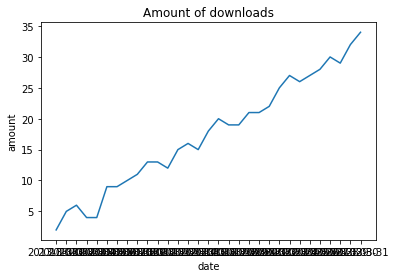

In [4]:
#a. Make a plot of the data so that you can already get some insight in the data.
def plotData(data):
	plt.figure()
	plt.plot(data['date'], data['downloads'])
	plt.xlabel('date')
	plt.ylabel('amount')
	plt.title('Amount of downloads')
	plt.show()

plotData(data)

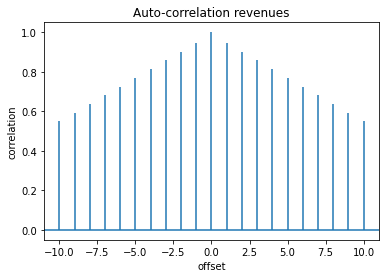

<Figure size 432x288 with 0 Axes>

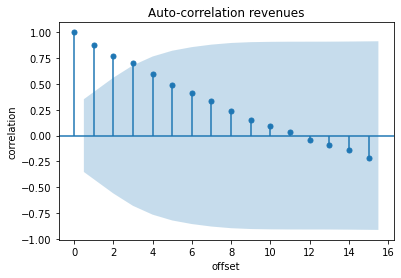

In [5]:
#b. Can you find the season size?
def determineSeasonSize(data):
	plt.figure()
	plt.acorr(data['downloads'].astype(float))
	plt.xlabel('offset')
	plt.ylabel('correlation')
	plt.title('Auto-correlation revenues')
	plt.show()

#better
def determineSeasonSizeStatsmodel(data):
	plt.figure()
	plot_acf(data['downloads'].astype(float), lags=15)
	plt.xlabel('offset')
	plt.ylabel('correlation')
	plt.title('Auto-correlation revenues')
	plt.show()

determineSeasonSize(data)
determineSeasonSizeStatsmodel(data)

In [6]:
#c. Forecast now, for each prediction method, the next three days. Calculate the MAE, RMSE and
#MAPE each time. Complete the following table with all results:

# Ours

def calculatePreviousForecasting(past, predictor):
	predicted = []
	n = len(past)
	for i in range(0,n):
		predicted = predicted + [predictor(past[0:i])]
	return predicted


def naiveForecasting(past):
	if (len(past)<1):
		return math.nan
	return past[len(past)-1]

def averageForecasting(past):
	if (len(past)<1):
		return math.nan
	return pd.Series(past).mean()

def movingAverageForecasting(period):
	def result(past):
		n = len(past)
		if (n < period):
			return math.nan
		return pd.Series(past[(n-period):n]).mean()
	return result

def calculateWeights(period, past):
    n = len(past)
    if (n<2*period):
        return math.nan
    v = past[(n-2*period):(n-period)]
    for i in range(2,period+1):
        v = v + past[(n-2*period+i-1):(n-period+i-1)]
    M = np.array(v).reshape(period, period)
    v = past[(n-period):n]
    return np.linalg.solve(M, v)

def linearCombinationForecasting(period):
	#for linear combination: data has to be a list (not numpy array, df column,..) -> ex. print(linearCombinationForecasting(13)(list(data['downloads']))) works
    def result(past):
        n = len(past)
        if (n<2*period):
            return math.nan
        a = calculateWeights(period, past)
        return (past[(n-period):n]*a).sum()
    return result

def general_regression(x, y, degree=1, exp=False):
    func=lambda x:x # def fun(x): return[x]
    inv_func=lambda x:x
    if (exp):
        func=np.exp
        inv_func=np.log
    model = np.polyfit(x, inv_func(y), degree)
    line = np.poly1d(model)
    predict = lambda x:func(line(x))
    yyy = pd.Series(predict(x))
    se = math.sqrt(((yyy-y)**2).mean())
    R2 = (x.corr(inv_func(y)))**2
    result = [se, R2, predict]
    index = ['se', 'R2', 'predict']
    for i in range(1,len(model)+1):
        result = np.append(result, model[-i])
        index += chr(i+96) # to obtain the characters a,b,...
    result = pd.Series(result)
    result.index = index
    return result

def trendForecastingModel(past):
	n = len(past)
	x = pd.Series(range(0,n))
	y = pd.Series(past)
	reg = general_regression(x, y)
	return reg.predict

def calculateMAE(data):
	return data.abs().mean()

def calculateRMSE(data):
	return math.sqrt((data**2).mean())

def calculateMAPE(data, past):
	return (data/past).abs().mean()

def calculateMultipleDays(data, amountOfDays):
	for i in range(0, amountOfDays):
		#change function to whatever is needed
		processedData = linearCombinationForecasting(13)(list(data))
		print(processedData)
		data = data.append(pd.Series(processedData))

# #specific function for trend forecasting
def calculateMultipleDaysTrendForecasting(data, amountOfDays):
	for i in range(0, amountOfDays):
		processedData = trendForecastingModel(data)
		dataLength = len(data)
		print(processedData(dataLength))
		data = data.append(pd.Series(processedData(dataLength)))

def calculateSeason(period):
	SandR = pd.Series(data['downloads']) - trend
	n = len(SandR)
	seasonal = []
	for i in range(0, period):
		seasonal = seasonal + [SandR[list(range(i, n, period))].mean()]
	print(seasonal )

def findTrend(x, period):
	result = smooth(x, period)
	nan = [math.nan] * int(period/2)
	if (period % 2 == 0):
		result = smooth(result, 2)
	result = nan + result + nan
	return result

def smooth(x, period):
	result = []
	for i in range(0, len(x)-period+1):
		result = result + [np.mean(x[i:i+period])]
	return result

#Heads up: change to list(data['downloads']) when using linearCombinationForecasting, when using multiple

#predicted = calculatePreviousForecasting(data['downloads'], naiveForecasting)
#predicted = calculatePreviousForecasting(data['downloads'], averageForecasting)

#can replace the second parameter in calculatePreviousForecasting with forecast if needed (both work the same)
#Working for movingAverageForecasting and linear
#forecast = movingAverageForecasting(5)
#predicted = calculatePreviousForecasting(data['downloads'], forecast)
#errors = pd.Series(predicted) - data['downloads']

# #calculating errors with trend for MAE, RMSE and MAPE:
myTrend = trendForecastingModel(data['downloads'])

#31 = the amount of data (can use len() because amount varies from dataframe to dataframe, 31 is the amount in this scenario)
# #predicted = pd.Series(myTrend(range(0,31)))

predicted = pd.Series(myTrend(range(0,len(data))))

errors = predicted - data['downloads']

#other method
forecast = movingAverageForecasting(5)
forecast(data['downloads'])

print(movingAverageForecasting(5)(data['downloads']))
print(linearCombinationForecasting(13)(list(data['downloads'])))

calculateMultipleDaysTrendForecasting(data['downloads'], 3)

print(calculateMultipleDays(data['downloads'], 3))

#Calculate MAE, RMSE and MAPE

print(calculateMAE(errors))
print(calculateRMSE(errors))
print(calculateMAPE(errors, data['downloads']))

#Prediction method, day 31, day 32, day 33, MAE, 		RMSE, 		MAPE
#Naïve: 			34, 	34, 	34, 	1.533333, 	1.914854, 	0.1199493
#Average:			17.4387,17.48387,14.48387,8.2082828,9.302767,	0.4338687
#Moving (m=5)		30.6,	31.120,	31.344,	3.130769,	3.366578,	0.1835417
#Linear comb(m=13)	36.8321,37.3841,42.0988,1.531631,	1.780848,	0.0488565
#Trend 				33.30968,34.29879,35.28790,1.0036420,1.156301,	0.104034
#additive decomp.	
#multip. decomp.	

result=smts.seasonal_decompose(data['downloads'], model='additive', period=7)
print(result.trend)


30.6
36.832062651387986
33.30967741935484
34.29879032258064
35.287903225806446
36.832062651387986
37.384059324901976
42.0988083528733
None
1.003642039542144
1.1563008854848957
0.10403373056827915
0           NaN
1           NaN
2           NaN
3      5.571429
4      6.714286
5      7.571429
6      8.571429
7      9.857143
8     11.000000
9     11.857143
10    12.857143
11    13.571429
12    14.571429
13    15.571429
14    16.428571
15    17.428571
16    18.285714
17    19.000000
18    20.000000
19    21.000000
20    22.000000
21    23.000000
22    24.142857
23    25.142857
24    26.428571
25    27.428571
26    28.428571
27    29.428571
28          NaN
29          NaN
30          NaN
Name: trend, dtype: float64


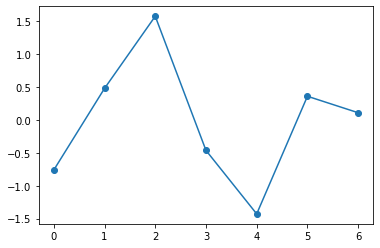

Formula for seasonal trend line: y = 2.8265934065934095 + 0.9738461538461536*x


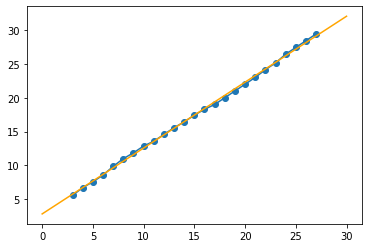

12.565054945054946

In [7]:
#c. Forecast now, for each prediction method, the next three days. Calculate the MAE, RMSE and
#MAPE each time. Complete the following table with all results:

# Dominik

def calculate_previous_forecasting(data, predictor):
    predicted = []
    n = len(data)
    for i in range(0, n):
        predicted = predicted + [predictor(data[0:i])]
    return predicted


def calculate_mae(past, predictor):
    predicted = calculate_previous_forecasting(past, predictor)
    errors = pd.Series(predicted) - past
    return errors.abs().mean()


def calculate_rmse(past, predictor):
    predicted = calculate_previous_forecasting(past, predictor)
    errors = pd.Series(predicted) - past
    return math.sqrt((errors ** 2).mean())


def calculate_mape(past, predictor):
    predicted = calculate_previous_forecasting(past, predictor)
    errors = pd.Series(predicted) - past
    return (errors / past).abs().mean()


def naive_forecasting(data):
    if len(data) < 1:
        return math.nan
    return data.iloc[len(data) - 1]


naive_predictions = [naive_forecasting(data['downloads']) for i in range(3)]
naive_errors = {'mae': calculate_mae(data['downloads'], naive_forecasting), 'rmse': calculate_rmse(data['downloads'], naive_forecasting),
                'mape': calculate_mape(data['downloads'], naive_forecasting)}


def average_forecasting(data):
    if len(data) < 1:
        return math.nan
    return pd.Series(data).mean()


average_predictions = data['downloads'].copy()
average_predictions = average_predictions.append(pd.Series([average_forecasting(average_predictions)]),
                                                 ignore_index=True)
average_predictions = average_predictions.append(pd.Series([average_forecasting(average_predictions)]),
                                                 ignore_index=True)
average_predictions = average_predictions.append(pd.Series([average_forecasting(average_predictions)]),
                                                 ignore_index=True)

average_errors = {'mae': calculate_mae(data['downloads'], average_forecasting), 'rmse': calculate_rmse(data['downloads'], average_forecasting),
                  'mape': calculate_mape(data['downloads'], average_forecasting)}


def moving_avg_forecasting(period):
    def result(data):
        n = len(data)
        if (n < period):
            return math.nan
        return pd.Series(data[(n - period):n]).mean()

    return result


moving_avg_5 = moving_avg_forecasting(5)

moving_avg_5_predictions = data['downloads'].copy()
moving_avg_5_predictions = moving_avg_5_predictions.append(pd.Series(moving_avg_5(moving_avg_5_predictions)),
                                                           ignore_index=True)
moving_avg_5_predictions = moving_avg_5_predictions.append(pd.Series(moving_avg_5(moving_avg_5_predictions)),
                                                           ignore_index=True)
moving_avg_5_predictions = moving_avg_5_predictions.append(pd.Series(moving_avg_5(moving_avg_5_predictions)),
                                                           ignore_index=True)


def calculateWeights(period, past):
    past = [*past]
    n = len(past)
    if (n < 2 * period):
        return math.nan
    v = past[(n - 2 * period):(n - period)]
    for i in range(2, period + 1):
        v = v + past[(n - 2 * period + i - 1):(n - period + i - 1)]
    M = np.array(v).reshape(period, period)
    v = past[(n - period):n]
    return np.linalg.solve(M, v)


def linearCombinationForecasting(period):
    def result(past):
        n = len(past)
        if (n < 2 * period):
            return math.nan
        a = calculateWeights(period, past)
        return (past[(n - period):n] * a).sum()

    return result


linear_comb_13 = linearCombinationForecasting(13)

linear_comb_predictions = data['downloads'].copy()

linear_comb_predictions = linear_comb_predictions.append(pd.Series(linear_comb_13(linear_comb_predictions)),
                                                         ignore_index=True)
linear_comb_predictions = linear_comb_predictions.append(pd.Series(linear_comb_13(linear_comb_predictions)),
                                                         ignore_index=True)
linear_comb_predictions = linear_comb_predictions.append(pd.Series(linear_comb_13(linear_comb_predictions)),
                                                         ignore_index=True)


def general_regression(x, y, degree=1, exp=False, log=False):
    data = pd.DataFrame({'x': x, 'y': y})
    data.reset_index(drop=True, inplace=True)
    func = lambda x: x  # def func(x): return[x]
    inv_func = lambda x: x
    if (exp):
        func = np.exp
        inv_func = np.log
    # elif (log):
    # func = lambda x: math.log(x)
    # inv_func = lambda x: x.apply(lambda z: math.log(z))
    sy = data.y.std()
    model = np.polyfit(x, inv_func(y), degree)
    line = np.poly1d(model)
    predict = lambda x: func(line(x))
    data['y_pred'] = pd.Series(predict(x))
    se = math.sqrt(((data.y_pred - data.y) ** 2).mean())
    R2 = 1 - (se ** 2) / (sy ** 2)
    result = [se, R2, predict]
    index = ['se', 'R²', 'predict']
    for i in range(1, len(model) + 1):
        result = np.append(result, model[-i])
        index += chr(i + 96)  # to obtain the characters a,b,...

    result = pd.Series(result)
    result.index = index
    return result


def trend_forecasting_model(data):
    n = len(data)
    x = pd.Series(range(0, n))
    y = pd.Series(data)
    reg = general_regression(x, y)
    return reg

def calculateSeason(period):
	SandR = pd.Series(data['downloads']) - trend
	n = len(SandR)
	seasonal = []
	for i in range(0, period):
		seasonal = seasonal + [SandR[list(range(i, n, period))].mean()]
	print(seasonal )



trend_estimation = trend_forecasting_model(data['downloads'])

trend_estimation_predictions = pd.Series(
    [trend_estimation.predict(n), trend_estimation.predict(n + 1), trend_estimation.predict(n + 2)])


def smooth(x, period):
    result = []
    for i in range(0, len(x) - period + 1):
        result = result + [np.mean(x[i:i + period])]
    return result


def find_trend(x, period):
    result = smooth(x, period)
    nan = [math.nan] * int(period / 2)
    if period % 2 == 0:
        result = smooth(result, 2)
    result = nan + result + nan
    return result


period = 7
trend = find_trend(data['downloads'], period)

S_and_R = pd.Series(data['downloads']) - find_trend(data['downloads'], period)
season_factor = []
for i in range(0, period):
    season_values = S_and_R[list(range(i, len(S_and_R), period))]
    season_values = season_values[~(np.isnan(season_values))]
    season_factor = season_factor + [season_values.mean()]

plt.figure()
plt.plot(range(0, len(season_factor)), season_factor, 'o-')
plt.show()

seasonal = []
for i in range(0, len(data['downloads'])):
    seasonal = seasonal + [season_factor[i % period]]

# TODO: shift range by dropped na
shift = 0
for i in range(n):
    if trend[i] is math.nan:
        shift += 1
    else:
        break

general_trend = general_regression([*range(0+shift, len(pd.Series(trend).dropna())+shift)], pd.Series(trend).dropna())
print('Formula for seasonal trend line: y = {} + {}*x'.format(general_trend.a,general_trend.b))

pd.Series(trend).dropna()
plt.figure()
plt.plot(range(0, len(trend)), trend, 'o-')
plt.plot(range(0, len(trend)), [general_trend.predict(n) for n in range(0, len(trend))], '-', color='orange')
plt.show()

[general_trend.predict(n) for n in range(0, len(trend))]
general_trend.predict(10)

In [8]:
#d. Linear combination: Which weights do you find? Which value plays the greatest role in predicting
#the next value?

print(calculateWeights(13,list(data['downloads'])))

[-1.37904976 -0.15565187 -0.23776957  1.8163469  -0.38610905  1.25825395
 -0.34509882  1.55050889  0.08601697 -0.23792256 -0.09817519 -0.4999042
 -0.06770171]


In [12]:
dataCorr = data.drop(['vdate'])

add_season_fore = smts.seasonal_decompose(dataCorr, model='additive', period=7)
multi_season_fore = smts.seasonal_decompose(dataCorr, model='multiplicative', period=7)

def general_regression(x, y, degree=1, exp=False, log=False):
    data = pd.DataFrame({'x': x, 'y': y})
    data.reset_index(drop=True, inplace=True)
    func = lambda x: x  # def func(x): return[x]
    inv_func = lambda x: x
    if (exp):
        func = np.exp
        inv_func = np.log
    # elif (log):
    # func = lambda x: math.log(x)
    # inv_func = lambda x: x.apply(lambda z: math.log(z))
    sy = data.y.std()
    model = np.polyfit(x, inv_func(y), degree)
    line = np.poly1d(model)
    predict = lambda x: func(line(x))
    data['y_pred'] = pd.Series(predict(x))
    se = math.sqrt(((data.y_pred - data.y) ** 2).mean())
    R2 = 1 - (se ** 2) / (sy ** 2)
    result = [se, R2, predict]
    index = ['se', 'R²', 'predict']
    for i in range(1, len(model) + 1):
        result = np.append(result, model[-i])
        index += chr(i + 96)  # to obtain the characters a,b,...

    result = pd.Series(result)
    result.index = index
    return result


def best_fit_Rsquare(x, y):
    linear = general_regression(x, y)['R²']
    quadratic = general_regression(x, y, 2)['R²']
    cubic = general_regression(x, y, 3)['R²']
    exp = general_regression(x, y, 1, exp=True)['R²']
    log = general_regression(x, y, 1, log=True)['R²']
    results = pd.DataFrame(columns=['type', 'R^2'])
    results.loc[len(results)] = ['linear', linear]
    results.loc[len(results)] = ['quadratic', quadratic]
    results.loc[len(results)] = ['cubic', cubic]
    results.loc[len(results)] = ['exp', exp]
    results.loc[len(results)] = ['log', log]
    results.set_index('type', inplace=True)
    return results


period = 7
low = period // 2
high = len(dataCorr) - period // 2

x = pd.Series(range(low, high))
y = pd.Series(add_season_fore.trend[low:high])

best_fit_Rsquare(x, y).idxmax()

reg = general_regression(x, y, degree=2)


def pred_value_add(n):
    return reg.predict(n) + add_season_fore.seasonal[n % period]


def pred_value_multi(n):
    return reg.predict(n) * multi_season_fore.seasonal[n % period]


def forecast_add(past):
    return pred_value_add(len(past))

def forecast_multi(past):
    return pred_value_multi(len(past))

calculate_mae(dataCorr, forecast_add)

KeyError: "['vdate'] not found in axis"

In [8]:
#e. Trend estimation: What is the formula of the regression line?
myTrend = trend_forecasting_model(data['downloads'])
print(myTrend(0))

TypeError: 'Series' object is not callable

In [24]:
#f. Additive decomposition: What is the formula for the trend line?


In [25]:
#g. Additive decomposition: What are the values for the recurring pattern (seasonal trend)?
trend = find_trend(data['downloads'], 7)
calculateSeason(7)

[-0.7619047619047615, 0.4761904761904769, 1.5714285714285718, -0.46428571428571397, -1.4285714285714282, 0.35714285714285765, 0.10714285714285765]


In [26]:
#h. Multiplier decomposition: What is the formula for the trend line?


In [27]:
#i. Multiplicative decomposition: What are the values for the recurring pattern (seasonal trend)?

In [28]:
#j. Which technique gives the best prediction and why? --> linear, in this situation this has the lowest MAPE value (the lower, the more accurate)